In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.path.abspath('../src/'))
sys.path.append(os.path.abspath('../'))

In [2]:
from src.central_ids import IDS
from src.utils import cal_metric, print_results
from src.dataset import CANDataset
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import numpy as np
from pathlib import Path
from sklearn.metrics import f1_score
import pickle
import torch
from flwr.common.parameter import parameters_to_ndarrays
from collections import OrderedDict
from utils import set_parameters

In [3]:
rnd = 44
ckpt_file = f'../save/FedAvg/train1000_50rnds_3/ckpt-rnd{rnd}.npz'
tensors = np.load(ckpt_file, allow_pickle=True)['arr_0'][()]
model = IDS(C = 2)

In [4]:
weights = parameters_to_ndarrays(tensors)
params_dict = zip(model.state_dict().keys(), weights)
state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
model.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [5]:
def evaluate(model):
    transform = None
    data_dir = '../../Data/LISA/{}/1/'
    car_models = ['Kia', 'Tesla', 'BMW']
    res = []
    total_labels = np.array([])
    total_preds = np.array([])
    for car_model in car_models:
        print(f'Run test on {car_model} dataset')
        test_dataset = CANDataset(root_dir=Path(data_dir.format(car_model))/'test', is_binary=True, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, 
                                pin_memory=True, sampler=None)
        trainer = pl.Trainer(enable_checkpointing=False, logger=False, gpus=[0])
        results = trainer.predict(model, dataloaders=test_loader)
        labels = np.concatenate([x['labels'] for x in results])
        preds = np.concatenate([x['preds'] for x in results])
        f1 = f1_score(labels, preds)
        res.append(f1)
        total_labels = np.concatenate([total_labels, labels])
        total_preds = np.concatenate([total_preds, preds])
    car_models.append('Global')
    f1_global = f1_score(total_labels, total_preds)
    res.append(f1_global)
    return (car_models, res)

In [6]:
car_models, res = evaluate(model)

Run test on Kia dataset


/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUs

Predicting: 0it [00:00, ?it/s]

Run test on Tesla dataset


/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUs

Predicting: 0it [00:00, ?it/s]

Run test on BMW dataset


/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUs

Predicting: 0it [00:00, ?it/s]

In [8]:
for name, value in zip(car_models, res):
    print(name, round(value, 4))

print('Avg ', np.mean(res))

Kia 0.9176
Tesla 0.8553
BMW 0.7012
Global 0.7847
Avg  0.8146840841194037


In [10]:
file_name = '../save/FedAvg/train1000_50rnds_2/hist.pkl'
f = open(file_name, 'rb')
hist = pickle.load(f)
f.close()

In [15]:
f1_avg = hist.metrics_centralized['f1_avg']
f1_avg = [x[1] for x in f1_avg]

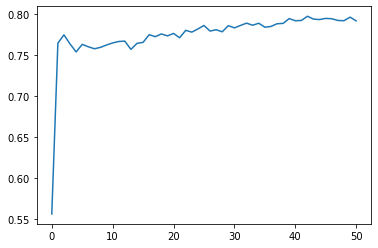

In [16]:
from matplotlib import pyplot as plt

plt.plot(range(len(f1_avg)), f1_avg)